#Загрузка библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.4 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 1.4 MB 4.2 MB/s 
     |████████████████████████████████| 65 kB 3.7 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=6a68cd719541ad7c54d23e8cb770add39fdf61e119aec18a84bd8552075dd0c0
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [3]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 2.1 MB/s 


In [4]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.3 MB/s 


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor

import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

# Знакомство с данными

1) issues.csv

● id - идентификатор задачи в глобальной базе данных

● created - дата создания задачи

● key - ключ задачи, используется для идентификации задачи
внутри проекта

● summary - описание задачи

● project_id - идентификатор проекта, по которому выполняется
задача

● assignee_id - идентификатор сотрудника, на которого назначена
задача (таблица сотрудников)

● creator_id - идентификатор сотрудника, который создал задачу
(таблица сотрудников)

● overall_worklogs - количество времени в секундах, ушедшего на
решение задачи

2) comments.csv

● comment_id - идентификатор комментария

● text - текст комментария

● issue_id - идентификатор задачи (таблица задач)

● author_id - идентификатор автора комментария (таблица
сотрудники)


In [6]:
PATH = '/content/drive/My Drive/collector'

In [7]:
df_issues_train = pd.read_csv(PATH + "/train_dataset_train/train_issues.csv")
df_comment_train = pd.read_csv(PATH + "/train_dataset_train/train_comments.csv")

df_emp = pd.read_csv(PATH + "/employees.csv")

In [8]:
df_issues_test = pd.read_csv(PATH + "/test_dataset_test/test_issues.csv")
df_comment_test = pd.read_csv(PATH + "/test_dataset_test/test_comments.csv")
df_issues_test.head()

,id,created,key,summary,project_id,assignee_id,creator_id
0,675975,2020-01-15 09:52:57.000,SM-11140,Выгрузить все mp3 файлы звонков на диск,5,112,112
1,675972,2020-01-15 09:54:35.000,SM-11141,Удалить файлы mp3 звонков с сервера до 01.01.2019,5,112,112
2,675965,2020-01-16 04:46:17.000,SM-11144,Удалить окно выбора тарифов и перенести функци...,5,94,54
3,675961,2020-01-16 11:12:18.000,SM-11146,При авторизации пользователь/водитель не видит...,5,94,94
4,675955,2020-01-17 05:19:39.000,SM-11150,Основные проблемы по корп. отделу (по состояни...,5,1,54


In [9]:
train_eng = pd.read_csv(PATH + "/train_eng.csv")
test_eng = pd.read_csv(PATH + "/test_eng.csv")


com_train_eng = pd.read_csv(PATH + "/df_comment_train_eng.csv")
com_test_eng = pd.read_csv(PATH + "/df_comment_test_eng.csv")

df_comment_train['text'] = com_train_eng['text']
df_comment_test['text'] = com_test_eng['text']

df_issues_train = df_issues_train.sort_values(by='created')
df_issues_test = df_issues_test.sort_values(by='created')

train_eng = train_eng.sort_values(by='created')
test_eng = test_eng.sort_values(by='created')

df_issues_train['summary'] = train_eng['summary']
df_issues_test['summary'] = test_eng['summary']

df_issues_train.head()

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
7250,700722,2017-10-05 10:01:14.000,UN-1,Research payment model strategies,15,22,37,14400
7251,700721,2017-10-05 10:08:53.000,UN-2,Explore infrastructure,15,1,37,25200
7252,700719,2017-10-06 07:45:43.000,UN-4,Create paper component,15,1,37,10800
7253,700718,2017-10-06 08:02:02.000,UN-5,Write unit-tests,15,13,37,32400
7254,700716,2017-10-06 08:37:59.000,UN-7,Frontend requests on endpoints,15,13,37,10800


# Немного переназовем позиции

In [10]:
# унифицируем позиции

df_emp.loc[df_emp['position']==' Системный администратор','position'] = 'Системный администратор'
df_emp.loc[df_emp['position']=='Web-разработчик ','position'] = 'Web-разработчик'
df_emp.loc[df_emp['position']=='Рекрутер','position'] = 'IT-рекрутер'
df_emp.loc[df_emp['position']=='DevOps инженер','position'] = 'DevOps engineer'
df_emp.loc[df_emp['position']=='Инженер-тестировщик','position'] = 'QA engineer'
df_emp.loc[df_emp['position']=='Инженер тестировщик (QA engineer)','position'] = 'QA engineer'
df_emp.loc[df_emp['position']=='офис-менеджер','position'] = 'Офис-менеджер'
df_emp.loc[df_emp['position']=='Web дизайнер','position'] = 'Web-дизайнер'
##### ??????????????
df_emp.loc[df_emp['position']=='Системный администратор (DevOps инженер)','position'] = 'DevOps engineer'





# Добавим данные о работниках

In [11]:
df_issues_train = pd.merge(df_issues_train, df_emp, how='left',left_on=['assignee_id'], right_on=['id'])
df_issues_test = pd.merge(df_issues_test, df_emp, how='left',left_on=['assignee_id'], right_on=['id'])


df_issues_train = df_issues_train.drop(['id_y'], axis=1)
df_issues_test = df_issues_test.drop(['id_y'], axis=1)

df_issues_train = df_issues_train.rename(columns={'id_x':'id'})
df_issues_test = df_issues_test.rename(columns={'id_x':'id'})


df_emp = df_emp.rename(columns={'position':'position_creator'})
df_issues_train = pd.merge(df_issues_train, df_emp[['id','position_creator']], how='left',left_on=['creator_id'], right_on=['id'])
df_issues_test = pd.merge(df_issues_test, df_emp[['id','position_creator']], how='left',left_on=['creator_id'], right_on=['id'])

df_issues_train = df_issues_train.drop(['id_y'], axis=1)
df_issues_test = df_issues_test.drop(['id_y'], axis=1)

df_issues_train = df_issues_train.rename(columns={'id_x':'id'})
df_issues_test = df_issues_test.rename(columns={'id_x':'id'})

In [12]:
df_issues_train.head()

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,active,full_name,...,hiring_type,payment_type,salary_calculation_type,english_level,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,position_creator
0,700722,2017-10-05 10:01:14.000,UN-1,Research payment model strategies,15,22,37,14400,1,Caroline Lawrence,...,staff,fixed,NaN,NaN,1,1,1,1,1,Менеджер проектов
1,700721,2017-10-05 10:08:53.000,UN-2,Explore infrastructure,15,1,37,25200,1,David Courtney,...,NaN,NaN,NaN,NaN,0,0,0,0,0,Менеджер проектов
2,700719,2017-10-06 07:45:43.000,UN-4,Create paper component,15,1,37,10800,1,David Courtney,...,NaN,NaN,NaN,NaN,0,0,0,0,0,Менеджер проектов
3,700718,2017-10-06 08:02:02.000,UN-5,Write unit-tests,15,13,37,32400,1,Joyce Carver,...,staff,fixed,NaN,NaN,1,1,1,1,1,Менеджер проектов
4,700716,2017-10-06 08:37:59.000,UN-7,Frontend requests on endpoints,15,13,37,10800,1,Joyce Carver,...,staff,fixed,NaN,NaN,1,1,1,1,1,Менеджер проектов


# Feature Engineering

In [13]:
# даты
df_issues_train['created'] = df_issues_train['created'].astype('datetime64')
df_issues_test['created'] = df_issues_test['created'].astype('datetime64')

In [14]:
df_issues_train['day'] = pd.to_datetime(df_issues_train.created).dt.strftime("%d").astype(int)
df_issues_train['month'] = pd.to_datetime(df_issues_train.created).dt.strftime("%m").astype(int)
df_issues_train['dw'] = pd.to_datetime(df_issues_train.created).dt.strftime("%w").astype(int)
df_issues_train['hour'] = pd.to_datetime(df_issues_train.created).dt.strftime("%H").astype(int)


df_issues_test['day'] = pd.to_datetime(df_issues_test.created).dt.strftime("%d").astype(int)
df_issues_test['month'] = pd.to_datetime(df_issues_test.created).dt.strftime("%m").astype(int)
df_issues_test['dw'] = pd.to_datetime(df_issues_test.created).dt.strftime("%w").astype(int)
df_issues_test['hour'] = pd.to_datetime(df_issues_test.created).dt.strftime("%H").astype(int)


In [15]:
df_issues_train['end'] = df_issues_train.created + pd.to_timedelta(df_issues_train.overall_worklogs, unit='seconds')


### Количество текущих задач

In [16]:
# количество задач и проектов для сотрудника к данному моменту

df_issues_train['train'] = 'train'
df_issues_test['train'] = 'test'


all = pd.concat([df_issues_train,df_issues_test])
all = all.sort_values(by = 'created')
all['all_tasks'] = all.groupby('assignee_id')['assignee_id'].transform('cumcount')
all['all_tasks_creator'] = all.groupby('creator_id')['creator_id'].transform('cumcount')
all['all_projects'] = all.groupby(['assignee_id', 'project_id'])['project_id'].transform('nunique')


df_issues_train = all[all['train'] == 'train'].sort_index()
df_issues_test = all[all['train'] == 'test'].sort_index()

df_issues_train = df_issues_train.drop(['train'], axis=1)
df_issues_test = df_issues_test.drop(['train'], axis=1)

In [17]:
df_issues_train['close'] = df_issues_train.groupby(['assignee_id'])['end'].transform('cumcount')

df_issues_train['tasks_all'] = df_issues_train['all_tasks'] - df_issues_train['close']

In [18]:
# сам поставил задачу
df_issues_train['self'] = 0
df_issues_train.loc[df_issues_train['assignee_id']==df_issues_train['creator_id'],'self']=1

df_issues_test['self'] = 0
df_issues_test.loc[df_issues_test['assignee_id']==df_issues_test['creator_id'],'self']=1

In [19]:
# количество задач на сотрудника  в этот день

df_issues_train['date'] = pd.to_datetime(df_issues_train['created']).dt.strftime('%Y/%m/%d')
df_issues_train['date'] = pd.to_datetime(df_issues_train['date'])

df_issues_test['date'] = pd.to_datetime(df_issues_test['created']).dt.strftime('%Y/%m/%d')
df_issues_test['date'] = pd.to_datetime(df_issues_test['date'])

df_issues_train['in_day'] = df_issues_train.groupby(['date','assignee_id'])['assignee_id'].transform('count')
df_issues_test['in_day'] = df_issues_test.groupby(['date','assignee_id'])['assignee_id'].transform('count')

In [20]:
# длина текста задачи

df_issues_train['len_summary'] = df_issues_train['summary'].str.len()
df_issues_test['len_summary'] = df_issues_test['summary'].str.len()



In [21]:
# расстояние между комментариями
df_comment_train['dist_com'] = df_comment_train.groupby(['issue_id'])['comment_id'].shift()

def fill_dist(df):
  if df['dist_com']!=df['dist_com']:
    df['dist_com']=df['comment_id']
  return df

df_comment_train = df_comment_train.apply(fill_dist,axis=1)

df_comment_train['dist_com'] = df_comment_train['comment_id'] - df_comment_train['dist_com']

df_comment_train['dist_com_sum'] = df_comment_train.groupby(['issue_id'])['dist_com'].transform('sum')


In [22]:
df_comment_test['dist_com'] = df_comment_test.groupby(['issue_id'])['comment_id'].shift()

def fill_dist(df):
  if df['dist_com']!=df['dist_com']:
    df['dist_com']=df['comment_id']
  return df

df_comment_test = df_comment_test.apply(fill_dist,axis=1)

df_comment_test['dist_com'] = df_comment_test['comment_id'] - df_comment_test['dist_com']

df_comment_test['dist_com_sum'] = df_comment_test.groupby(['issue_id'])['dist_com'].transform('sum')


In [23]:
### расстояние между комментариями
df_tr = df_comment_train.groupby(['issue_id','dist_com_sum'])['dist_com_sum'].count().reset_index(name='1').drop(['1'], axis=1)
df_te = df_comment_test.groupby(['issue_id','dist_com_sum'])['dist_com_sum'].count().reset_index(name='1').drop(['1'], axis=1)


df_issues_train = pd.merge(df_issues_train, df_tr, how='left',left_on=['id'], right_on=['issue_id'])
df_issues_test = pd.merge(df_issues_test, df_te, how='left',left_on=['id'], right_on=['issue_id'])

In [24]:
df_issues_train['dist_com_sum'] = df_issues_train['dist_com_sum'].fillna(0)
df_issues_test['dist_com_sum'] = df_issues_test['dist_com_sum'].fillna(0)
df_issues_train.head()

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,active,full_name,...,all_tasks_creator,all_projects,close,tasks_all,self,date,in_day,len_summary,issue_id,dist_com_sum
0,700722,2017-10-05 10:01:14,UN-1,Research payment model strategies,15,22,37,14400.0,1,Caroline Lawrence,...,0,1,0,0,0,2017-10-05,1,33,NaN,0.0
1,700721,2017-10-05 10:08:53,UN-2,Explore infrastructure,15,1,37,25200.0,1,David Courtney,...,1,1,0,0,0,2017-10-05,1,22,700721.0,10.0
2,700719,2017-10-06 07:45:43,UN-4,Create paper component,15,1,37,10800.0,1,David Courtney,...,2,1,1,0,0,2017-10-06,2,22,700719.0,349.0
3,700718,2017-10-06 08:02:02,UN-5,Write unit-tests,15,13,37,32400.0,1,Joyce Carver,...,3,1,0,0,0,2017-10-06,2,16,NaN,0.0
4,700716,2017-10-06 08:37:59,UN-7,Frontend requests on endpoints,15,13,37,10800.0,1,Joyce Carver,...,4,1,1,0,0,2017-10-06,2,30,NaN,0.0


In [25]:
# категория исполнитель-создатель

df_issues_train['assign_and_creator'] = df_issues_train['assignee_id'].astype('str') + df_issues_train['creator_id'].astype('str')
df_issues_test['assign_and_creator'] = df_issues_test['assignee_id'].astype('str') + df_issues_test['creator_id'].astype('str')

In [26]:
# количество комментариев

df = df_comment_train.issue_id.value_counts().reset_index()
df = pd.DataFrame(df)
df = df.rename(columns={'index':'id','issue_id':'count_com'})


In [27]:
df_issues_train = pd.merge(df_issues_train, df, how='left',left_on=['id'], right_on=['id'])

In [28]:
df = df_comment_test.issue_id.value_counts().reset_index()
df = pd.DataFrame(df)
df = df.rename(columns={'index':'id','issue_id':'count_com'})

In [29]:
df_issues_test = pd.merge(df_issues_test, df, how='left',left_on=['id'], right_on=['id'])

In [30]:
del df

In [31]:
# пропуски

df_issues_train['count_com'] = df_issues_train['count_com'].fillna(0)
df_issues_test['count_com'] = df_issues_test['count_com'].fillna(0)



### Количество задач за последние дни


In [32]:
df_issues_train['date_hour'] = pd.to_datetime(df_issues_train['created']).dt.strftime('%Y/%m/%d/%H')
df_issues_train['date_hour'] = pd.to_datetime(df_issues_train['date_hour'])

df_issues_test['date_hour'] = pd.to_datetime(df_issues_test['created']).dt.strftime('%Y/%m/%d/%H')
df_issues_test['date_hour'] = pd.to_datetime(df_issues_test['date_hour'])

In [33]:
# количество задач в последние часы
def count_in_hour(train, test, all, list_periods):
  for days in list_periods:
      timel = all.sort_values(by='date_hour').set_index('date_hour')
      timel = timel.groupby(['assignee_id', 'date_hour'])['assignee_id'].count()
      timel = timel.reset_index(name=f'count_in_{days}')
      timel = timel.set_index('date_hour')
      timel = timel.groupby('assignee_id')[f'count_in_{days}'].rolling(days).sum()
      timel = timel.reset_index(name=f'count_in_{days}')
      train = pd.merge(train, timel, how='left',left_on=['assignee_id', 'date_hour'], right_on=['assignee_id', 'date_hour'])

      test = pd.merge(test, timel, how='left',left_on=['assignee_id', 'date_hour'], right_on=['assignee_id', 'date_hour'])

  return train, test


all = pd.concat([df_issues_train,df_issues_test])
list_periods = ['1H', '2H', '4H', '6H', '12H', '24H']
df_issues_train,df_issues_test = count_in_hour(df_issues_train,df_issues_test, all, list_periods)


cols_count_hours = [f'count_in_{i}' for i in list_periods]
del all

In [34]:
# количество задач в последние дни
def count_in(train, test, all, list_periods):
  for days in list_periods:
      timel = all.sort_values(by='date').set_index('date')
      timel = timel.groupby(['assignee_id', 'date'])['assignee_id'].count()
      timel = timel.reset_index(name=f'count_in_{days}')
      timel = timel.set_index('date')
      timel = timel.groupby('assignee_id')[f'count_in_{days}'].rolling(days).sum()
      timel = timel.reset_index(name=f'count_in_{days}')
      train = pd.merge(train, timel, how='left',left_on=['assignee_id', 'date'], right_on=['assignee_id', 'date'])

      test = pd.merge(test, timel, how='left',left_on=['assignee_id', 'date'], right_on=['assignee_id', 'date'])

  return train, test


all = pd.concat([df_issues_train,df_issues_test])
list_periods = ['1D', '3D', '5D', '7D', '10D', '14D', '21D', '30D']
df_issues_train,df_issues_test = count_in(df_issues_train,df_issues_test, all, list_periods)

del all

In [35]:
cols_count = [f'count_in_{i}' for i in list_periods]

In [36]:
# кол-во секунд с предыдущего задания
r = pd.concat([df_issues_train, df_issues_test])
r = r.groupby(['assignee_id', 'created'])['created'].count()
r = r.reset_index(name='c')
r['shift_day'] = r.groupby('assignee_id')['created'].transform(lambda x: x.shift())
r['dist_seconds'] = (r['created'] - r['shift_day']).dt.seconds
r = r.fillna(0)

r = r.drop(['c','shift_day'], axis=1)



df_issues_train = pd.merge(df_issues_train, r, how='left',left_on=['assignee_id', 'created'], right_on=['assignee_id', 'created'])

df_issues_test = pd.merge(df_issues_test, r, how='left',left_on=['assignee_id', 'created'], right_on=['assignee_id', 'created'])

del r

In [37]:
# кол-во дней с предыдущего задания
r = pd.concat([df_issues_train, df_issues_test])
r = r.groupby(['assignee_id', 'date'])['date'].count()
r = r.reset_index(name='c')
r['shift_day'] = r.groupby('assignee_id')['date'].transform(lambda x: x.shift())
r['dist'] = (r['date'] - r['shift_day']).dt.days
r = r.fillna(0)

r = r.drop(['c','shift_day'], axis=1)



df_issues_train = pd.merge(df_issues_train, r, how='left',left_on=['assignee_id', 'date'], right_on=['assignee_id', 'date'])

df_issues_test = pd.merge(df_issues_test, r, how='left',left_on=['assignee_id', 'date'], right_on=['assignee_id', 'date'])

del r

# Переводчик

перевод на анг


In [38]:
# df_issues_train[~df_issues_train['summary'].str.match(r'.*[A-Za-z]')]

In [39]:
# import googletrans
# from googletrans import Translator

In [40]:
# translator = Translator()

In [41]:
# df_comment_train[df_comment_train['text'].str.match(r'.*[^\x00-\xFF]')]

In [42]:
# df_comment_train[df_comment_train['text'].str.match(r'.*[^\x00-\xFF]')]

In [43]:
# # train_com = df_comment_train[df_comment_train['text'].str.match(r'.*[^\x00-\xFF]')]
# # test_com = df_comment_test[df_comment_test['text'].str.match(r'.*[^\x00-\xFF]')]


# train_com = df_comment_train[~df_comment_train['text'].str.match(r'.*[A-Za-z]')]
# test_com = df_comment_test[~df_comment_test['text'].str.match(r'.*[A-Za-z]')]

In [44]:
# def trans(row):
#   res = translator.translate(row).text
#   return res

In [45]:
# df_issues_train['summary'] = df_issues_train['summary'].apply(trans)

In [46]:
# df_issues_test['summary'] = df_issues_test['summary'].apply(trans)

In [47]:
# df_issues_test.to_csv('test_eng.csv', index=False)

In [48]:
# df_issues_train['summary'] = df_issues_train['summary'].apply(trans)
# df_issues_test['summary'] = df_issues_test['summary'].apply(trans)

In [49]:
# train_com['text'] = train_com['text'].apply(trans)
# test_com['text'] = test_com['text'].apply(trans)

In [50]:
# df_comment_train.loc[train_com.index, 'text'] = train_com['text']
# df_comment_test.loc[test_com.index, 'text'] = test_com['text']


In [51]:
# df_comment_train.to_csv('df_comment_train_eng.csv', index=False)
# df_comment_test.to_csv('df_comment_test_eng.csv', index=False)

# Еще признаки

In [52]:
# количество комментирующих

df_comment_train['uniq_auth'] = df_comment_train.groupby(['issue_id'])['author_id'].transform('nunique')
df_comment_test['uniq_auth'] = df_comment_test.groupby(['issue_id'])['author_id'].transform('nunique')
df_comment_test.head()

,comment_id,text,issue_id,author_id,dist_com,dist_com_sum,uniq_auth
0,76324,I wasted much time building one graph by using...,670929,2,0.0,0.0,1
1,75499,read articles on transferring domains to cloud...,675831,112,0.0,20.0,1
2,75519,I looked again at how sites are transferred to...,675831,112,20.0,20.0,1
3,75490,I checked the imported records line by line in...,675834,112,0.0,0.0,1
4,75442,I wanted to find a way to automatically transf...,675836,112,0.0,0.0,1


In [53]:
df_com_train = df_comment_train[['issue_id','uniq_auth']].drop_duplicates()
df_com_test = df_comment_test[['issue_id','uniq_auth']].drop_duplicates()

In [54]:
df_issues_train = pd.merge(df_issues_train, df_com_train, how='left',left_on=['id'], right_on=['issue_id'])
df_issues_test = pd.merge(df_issues_test, df_com_test, how='left',left_on=['id'], right_on=['issue_id'])


df_issues_train['uniq_auth'] = df_issues_train['uniq_auth'].fillna(0)
df_issues_test['uniq_auth'] = df_issues_test['uniq_auth'].fillna(0)

In [55]:
# количество ссылок

# df_comment_train[df_comment_train['text'].str.contains('http')]
df_comment_train['http'] = df_comment_train['text'].apply(lambda x: x.count('http'))
df_comment_test['http'] = df_comment_train['text'].apply(lambda x: x.count('http'))

df_train_htt = df_comment_train.groupby(['issue_id'])['http'].sum().reset_index()
df_test_htt = df_comment_test.groupby(['issue_id'])['http'].sum().reset_index()

df_issues_train = pd.merge(df_issues_train, df_train_htt, how='left',left_on=['id'], right_on=['issue_id'])
df_issues_test = pd.merge(df_issues_test, df_test_htt, how='left',left_on=['id'], right_on=['issue_id'])
df_issues_train.head()

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,active,full_name,...,count_in_10D,count_in_14D,count_in_21D,count_in_30D,dist_seconds,dist,issue_id_y,uniq_auth,issue_id,http
0,700722,2017-10-05 10:01:14,UN-1,Research payment model strategies,15,22,37,14400.0,1,Caroline Lawrence,...,1.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,NaN,NaN
1,700721,2017-10-05 10:08:53,UN-2,Explore infrastructure,15,1,37,25200.0,1,David Courtney,...,1.0,1.0,1.0,1.0,0.0,0.0,700721.0,2.0,700721.0,0.0
2,700719,2017-10-06 07:45:43,UN-4,Create paper component,15,1,37,10800.0,1,David Courtney,...,3.0,3.0,3.0,3.0,77810.0,1.0,700719.0,1.0,700719.0,3.0
3,700718,2017-10-06 08:02:02,UN-5,Write unit-tests,15,13,37,32400.0,1,Joyce Carver,...,2.0,2.0,2.0,2.0,0.0,0.0,NaN,0.0,NaN,NaN
4,700716,2017-10-06 08:37:59,UN-7,Frontend requests on endpoints,15,13,37,10800.0,1,Joyce Carver,...,2.0,2.0,2.0,2.0,2157.0,0.0,NaN,0.0,NaN,NaN


In [56]:
df_issues_train['http'] = df_issues_train['http'].fillna(0)
df_issues_test['http'] = df_issues_test['http'].fillna(0)
df_issues_train.head()

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,active,full_name,...,count_in_10D,count_in_14D,count_in_21D,count_in_30D,dist_seconds,dist,issue_id_y,uniq_auth,issue_id,http
0,700722,2017-10-05 10:01:14,UN-1,Research payment model strategies,15,22,37,14400.0,1,Caroline Lawrence,...,1.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,NaN,0.0
1,700721,2017-10-05 10:08:53,UN-2,Explore infrastructure,15,1,37,25200.0,1,David Courtney,...,1.0,1.0,1.0,1.0,0.0,0.0,700721.0,2.0,700721.0,0.0
2,700719,2017-10-06 07:45:43,UN-4,Create paper component,15,1,37,10800.0,1,David Courtney,...,3.0,3.0,3.0,3.0,77810.0,1.0,700719.0,1.0,700719.0,3.0
3,700718,2017-10-06 08:02:02,UN-5,Write unit-tests,15,13,37,32400.0,1,Joyce Carver,...,2.0,2.0,2.0,2.0,0.0,0.0,NaN,0.0,NaN,0.0
4,700716,2017-10-06 08:37:59,UN-7,Frontend requests on endpoints,15,13,37,10800.0,1,Joyce Carver,...,2.0,2.0,2.0,2.0,2157.0,0.0,NaN,0.0,NaN,0.0


In [57]:
# длина комментариев 

df_comment_train['len_com'] = df_comment_train['text'].str.len()
df_comment_test['len_com'] = df_comment_test['text'].str.len()

df_train_len = df_comment_train.groupby(['issue_id'])['len_com'].sum().reset_index()
df_test_len = df_comment_test.groupby(['issue_id'])['len_com'].sum().reset_index()

df_issues_train = pd.merge(df_issues_train, df_train_len, how='left',left_on=['id'], right_on=['issue_id'])
df_issues_test = pd.merge(df_issues_test, df_test_len, how='left',left_on=['id'], right_on=['issue_id'])

df_issues_train['len_com'] = df_issues_train['len_com'].fillna(0)
df_issues_test['len_com'] = df_issues_test['len_com'].fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'issue_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'issue_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [58]:
# сердняя длина комментариев

df_issues_train['mean_len_com'] = df_issues_train['len_com']/df_issues_train['count_com']
df_issues_test['mean_len_com'] = df_issues_test['len_com']/df_issues_test['count_com']


df_issues_train['mean_len_com'] = df_issues_train['mean_len_com'].replace(np.inf, -1)
df_issues_train['mean_len_com'] = df_issues_train['mean_len_com'].replace(-np.inf, -1)

df_issues_test['mean_len_com'] = df_issues_test['mean_len_com'].replace(np.inf, -1)
df_issues_test['mean_len_com'] = df_issues_test['mean_len_com'].replace(-np.inf, -1)

df_issues_train['mean_len_com'] = df_issues_train['mean_len_com'].fillna(0)
df_issues_test['mean_len_com'] = df_issues_test['mean_len_com'].fillna(0)


In [59]:
df_issues_train.fillna(-999, inplace=True)
# df_issues_test.fillna(-999, inplace=True)

## Временной промежуток для сбора статистик

In [60]:
up = df_issues_train['overall_worklogs'].quantile(0.99)

train_for_stats = df_issues_train[(df_issues_train['overall_worklogs']<=up)]


In [61]:
# статистики по работникам и должностям
list_stats = ['mean', 'std', 'min', 'max', 'mode', 'median']
def stat(df,df_test, col, list_stats):
  for stat in list_stats:
      if stat=='mode':
        df[f'{col}_{stat}'] = df.groupby(col)['overall_worklogs'].transform(lambda S: S.mode()[0])
        dict_pm = pd.Series(df[f'{col}_{stat}'].values,index=df[col]).to_dict()
        df_test[f'{col}_{stat}'] = df_test[col].map(dict_pm)

      # elif stat=='cov':
      #   df[f'{col}_{stat}'] = df.groupby(col)['overall_worklogs'].transform(lambda x: x[f'{col}_std']/x[f'{col}_mean'])

      #   dict_pm = pd.Series(df[f'{col}_{stat}'].values,index=df_issues_train[col]).to_dict()
      #   df_test[f'{col}_{stat}'] = df_test[col].map(dict_pm)

      elif stat=='median':
        df[f'{col}_{stat}'] = df.groupby(col)['overall_worklogs'].transform(lambda x: np.median(x))
        dict_pm = pd.Series(df[f'{col}_{stat}'].values,index=df[col]).to_dict()
        df_test[f'{col}_{stat}'] = df_test[col].map(dict_pm)
      else:
        df[f'{col}_{stat}'] = df.groupby(col)['overall_worklogs'].transform(stat)

        dict_pm = pd.Series(df[f'{col}_{stat}'].values,index=df[col]).to_dict()
        df_test[f'{col}_{stat}'] = df_test[col].map(dict_pm)

  return df, df_test

cols_for_stats = ['position', 'assignee_id','creator_id',
                  'project_id', 
                  # 'label_task', 'label_com','position_creator',
                  # 'self'
                  # 'top1_similar','top2_similar','top3_similar','top4_similar',
                  # 'top5_similar',
                  # 'top1_similar_com','top2_similar_com','top3_similar_com','top4_similar_com',
                  # 'top5_similar_com'
                  ]

for col in cols_for_stats:
  train_for_stats, df_issues_test = stat(train_for_stats, df_issues_test, col, list_stats)

for col in cols_for_stats:
  train_for_stats[f'{col}_cov'] = train_for_stats[f'{col}_std']/train_for_stats[f'{col}_mean']
  df_issues_test[f'{col}_cov'] = df_issues_test[f'{col}_std']/df_issues_test[f'{col}_mean']


cols_stat = []
for i in cols_for_stats:
  for st in ['mean', 'std', 'min', 'max', 'mode', 'cov', 'median']:
    cols_stat.append(f'{i}_{st}')





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

# Временной промежуток

In [62]:
train = train_for_stats[(train_for_stats['date']>='2019')]


# Обучение

In [63]:
def select_best_features(df_train: pd.DataFrame,cols, cat_features,
                        target_col: str,
                       
                        k_best=300,
                        n_splits = 50,
                        test_size=.3):
  


  
  all_importances = pd.DataFrame(index=cols)

  print('Feature selection started...')

  for counter in range(n_splits):
        print(f'{counter} из {n_splits}')
        train, _ = train_test_split(df_train, test_size=test_size, random_state=counter)

        model_cat = CatBoostRegressor(loss_function= 'RMSE', iterations=500, 
                                         verbose=100, 
                                         cat_features=cat_features)
          
        model_cat.fit(train[cols], train[target_col])

        # # считаем importances
        importances_df = pd.DataFrame(
            data=model_cat.feature_importances_,
            index=cols,
            columns=[f'importance{counter}'])

        all_importances = all_importances.join(importances_df, how='outer')

  all_importances['imortance_mean'] = all_importances.mean(axis=1)
  all_importances['imortance_std'] = all_importances.std(axis=1)
  all_importances = all_importances.sort_values(by='imortance_mean', ascending=False)

  best_features = all_importances.index[:k_best].to_list()
  print('\nDone!')

  return best_features, all_importances

In [64]:
train.fillna(-999, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [65]:
cols = ['project_id', 'assignee_id','creator_id', 'month', 
        'dw', 'hour',
       'all_tasks',
        'all_tasks_creator',
        'position', 'hiring_type',
       'payment_type', 
        'salary_calculation_type', 'english_level', 'passport', 'is_nda_signed',
       'is_labor_contract_signed', 'is_added_to_internal_chats',
       'is_added_one_to_one',

        'self', 'in_day', 'len_summary', 


        'count_com',
        'http',
        'len_com',
        'uniq_auth',
         'mean_len_com',
        'dist_com_sum',
  
        'dist',
  
        'position_creator',


        'dist_seconds'
   
       
        
        ]

cols = cols + cols_count + cols_stat


cat_features = ['project_id', 'assignee_id',
       'creator_id', 

      'month', 
       'dw', 'hour', 'position', 'hiring_type',
       'payment_type', 'self',
       
       'salary_calculation_type', 'english_level', 'passport', 'is_nda_signed',
       'is_labor_contract_signed', 'is_added_to_internal_chats',
       'is_added_one_to_one',

       'position_creator'
        ]

cat_features = cat_features



target_col = 'overall_worklogs'


In [66]:
best_features_views, all_importances_views = select_best_features(train,
                                                                  cols,
                                                                  cat_features, 
                                                                  target_col,
                       k_best=100,
                        n_splits = 50,
                        test_size=0.15)

Feature selection started...
0 из 50
Learning rate set to 0.098165
0:	learn: 16249.5751304	total: 121ms	remaining: 1m
100:	learn: 13290.8736260	total: 6.37s	remaining: 25.2s
200:	learn: 12545.6908141	total: 11.7s	remaining: 17.4s
300:	learn: 12007.0260172	total: 14.2s	remaining: 9.4s
400:	learn: 11482.7062174	total: 16.7s	remaining: 4.13s
499:	learn: 11080.5663793	total: 19.2s	remaining: 0us
1 из 50
Learning rate set to 0.098165
0:	learn: 16026.3352146	total: 26.6ms	remaining: 13.3s
100:	learn: 13352.7928626	total: 2.33s	remaining: 9.21s
200:	learn: 12597.8943303	total: 4.86s	remaining: 7.24s
300:	learn: 12022.7206793	total: 7.44s	remaining: 4.92s
400:	learn: 11513.5900314	total: 10s	remaining: 2.48s
499:	learn: 11031.7862140	total: 12.6s	remaining: 0us
2 из 50
Learning rate set to 0.098165
0:	learn: 16197.3055820	total: 27.2ms	remaining: 13.6s
100:	learn: 13324.2464171	total: 2.41s	remaining: 9.53s
200:	learn: 12618.2257354	total: 4.84s	remaining: 7.21s
300:	learn: 11997.6546349	total

In [67]:
all_importances_views[['imortance_mean','imortance_std']].head(40)

,imortance_mean,imortance_std
len_com,9.721601,0.709423
dist_com_sum,5.119852,0.629966
len_summary,4.384016,0.503911
creator_id_std,4.336046,0.883688
all_tasks,3.850186,0.513582
hour,3.716988,0.615656
all_tasks_creator,3.590978,0.391965
month,3.462746,0.482677
assignee_id_std,3.450968,0.740507
dist_seconds,3.373740,0.429437


In [68]:
# функция для кроссвалидации
def cross_val_kfold(df, model, params, cols, target_col):
    

    imp_df = pd.DataFrame()
    res_df = pd.DataFrame(columns=['nums', 'results'])
    results = []

    kf = KFold(n_splits=8, random_state=None)
    n = 0
    for tra_idx, val_idx in kf.split(df):
        n += 1
        # выборки

        x_train = df[cols].iloc[tra_idx]
        y_train = df[target_col].iloc[tra_idx]

        x_val = df[cols].iloc[val_idx]
        y_val = df[target_col].iloc[val_idx]



        # модель
        model.fit(x_train, y_train, **params, eval_set = (x_val,y_val))
        res = model.predict(x_val)


        # результаты

        importances = model.feature_importances_
        df_importances = pd.DataFrame(index=x_train[cols].columns, columns=['importance'], data=importances)
        df_importances = df_importances.sort_values(by='importance',ascending=False)
        imp_df[f'fold_{n}'] = df_importances.index
        imp_df[f'fold_{n}_imp'] = df_importances['importance'].to_list()

        temp_df = pd.DataFrame({'nums':x_val.index, 'results':res})
        res_df = res_df.append(temp_df, ignore_index=True)

        r2 = r2_score(y_val,res)

        results.append(r2)

    return results, res_df, imp_df

In [69]:
model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    iterations=4000, 
    depth = 6,
    verbose=100, 
   cat_features=cat_features,
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}


res, res_all, impot = cross_val_kfold(train, model_cat, params, cols, target_col)

Learning rate set to 0.029908
0:	learn: 16723.6246601	test: 14282.4706799	best: 14282.4706799 (0)	total: 29.4ms	remaining: 1m 57s
100:	learn: 14517.8086982	test: 12586.1448532	best: 12586.0219332 (99)	total: 2.63s	remaining: 1m 41s
200:	learn: 14048.1642787	test: 12376.5840974	best: 12376.5840974 (200)	total: 5.2s	remaining: 1m 38s
300:	learn: 13757.5205507	test: 12304.9484180	best: 12304.9484180 (300)	total: 7.79s	remaining: 1m 35s
400:	learn: 13486.3369248	test: 12326.8637437	best: 12302.4623543 (305)	total: 10.4s	remaining: 1m 33s
500:	learn: 13260.7520947	test: 12338.1379071	best: 12302.4623543 (305)	total: 12.9s	remaining: 1m 30s
600:	learn: 13022.8306875	test: 12328.9746669	best: 12302.4623543 (305)	total: 15.6s	remaining: 1m 28s
700:	learn: 12819.4976483	test: 12347.1983918	best: 12302.4623543 (305)	total: 18.3s	remaining: 1m 26s
800:	learn: 12659.0559321	test: 12341.7403281	best: 12302.4623543 (305)	total: 21s	remaining: 1m 23s
900:	learn: 12495.1310263	test: 12329.4348139	best

In [70]:
res, np.mean(res)

([0.2468905140683989,
  0.23541997164562556,
  0.23466000912538543,
  0.19151514545417392,
  0.14947767534527956,
  0.23939092671271767,
  0.09200533098144026,
  0.2123420907251916],
 0.2002127080072766)

In [71]:
res_all['overall_worklogs'] = train['overall_worklogs'].reset_index(drop=True)
r2_score(res_all['overall_worklogs'],res_all['results'])


0.20873006440134512

In [72]:
impot.head(50)

,fold_1,fold_1_imp,fold_2,fold_2_imp,fold_3,fold_3_imp,fold_4,fold_4_imp,fold_5,fold_5_imp,fold_6,fold_6_imp,fold_7,fold_7_imp,fold_8,fold_8_imp
0,len_com,16.225262,len_com,7.788616,len_com,13.370546,len_com,11.679328,len_com,13.806851,len_com,6.881486,len_com,20.789630,len_com,10.703831
1,creator_id_mean,5.971084,len_summary,5.967216,dist_com_sum,6.873689,dist_com_sum,5.844139,creator_id_std,6.146359,hour,5.170671,assignee_id_std,10.775826,creator_id_std,5.590173
2,dist_com_sum,5.749555,hour,5.550606,assignee_id_std,5.233848,creator_id_std,5.372978,dist_com_sum,5.807640,dist_com_sum,4.935257,creator_id_mean,9.487564,dist_com_sum,5.548405
3,assignee_id_std,5.584164,dist_seconds,4.411459,count_com,4.581406,creator_id_mean,4.937805,assignee_id_mean,5.126582,count_com,4.895907,creator_id_std,6.701805,count_com,4.975549
4,creator_id_std,4.521124,all_tasks,4.157804,creator_id_mean,4.194124,assignee_id_std,4.802477,assignee_id_std,4.672469,creator_id_std,4.082280,assignee_id_mean,4.855835,assignee_id_std,4.334889
5,count_com,4.416740,all_tasks_creator,3.903982,assignee_id_mean,4.051727,count_com,4.478273,count_com,4.641119,assignee_id_std,3.624888,count_com,4.656421,assignee_id_mean,3.822319
6,assignee_id_mean,4.329110,month,3.712786,creator_id_std,3.665420,assignee_id_mean,4.342720,creator_id_mean,4.213506,creator_id_mean,3.543095,count_in_1D,4.352596,all_tasks,3.703458
7,hour,3.968819,dist_com_sum,3.523409,hour,3.303893,hour,3.120794,hour,3.880196,len_summary,3.520412,creator_id_median,4.092758,month,3.627652
8,mean_len_com,2.670628,mean_len_com,3.116794,mean_len_com,3.166332,len_summary,3.080647,month,3.347533,month,3.467102,dist_com_sum,3.899487,len_summary,3.479368
9,count_in_10D,2.388510,count_in_14D,3.087864,len_summary,2.962838,assignee_id_median,2.781353,count_in_14D,3.284556,assignee_id_mean,3.339395,count_in_30D,3.085973,hour,3.390136


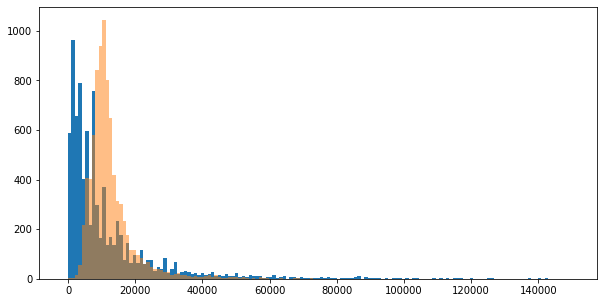

In [73]:
plt.figure(figsize=(10,5))
bins = np.linspace(-1000, 150000, 150)

plt.hist(res_all['overall_worklogs'], bins)
plt.hist(res_all.results, bins, alpha=0.5)
plt.show()


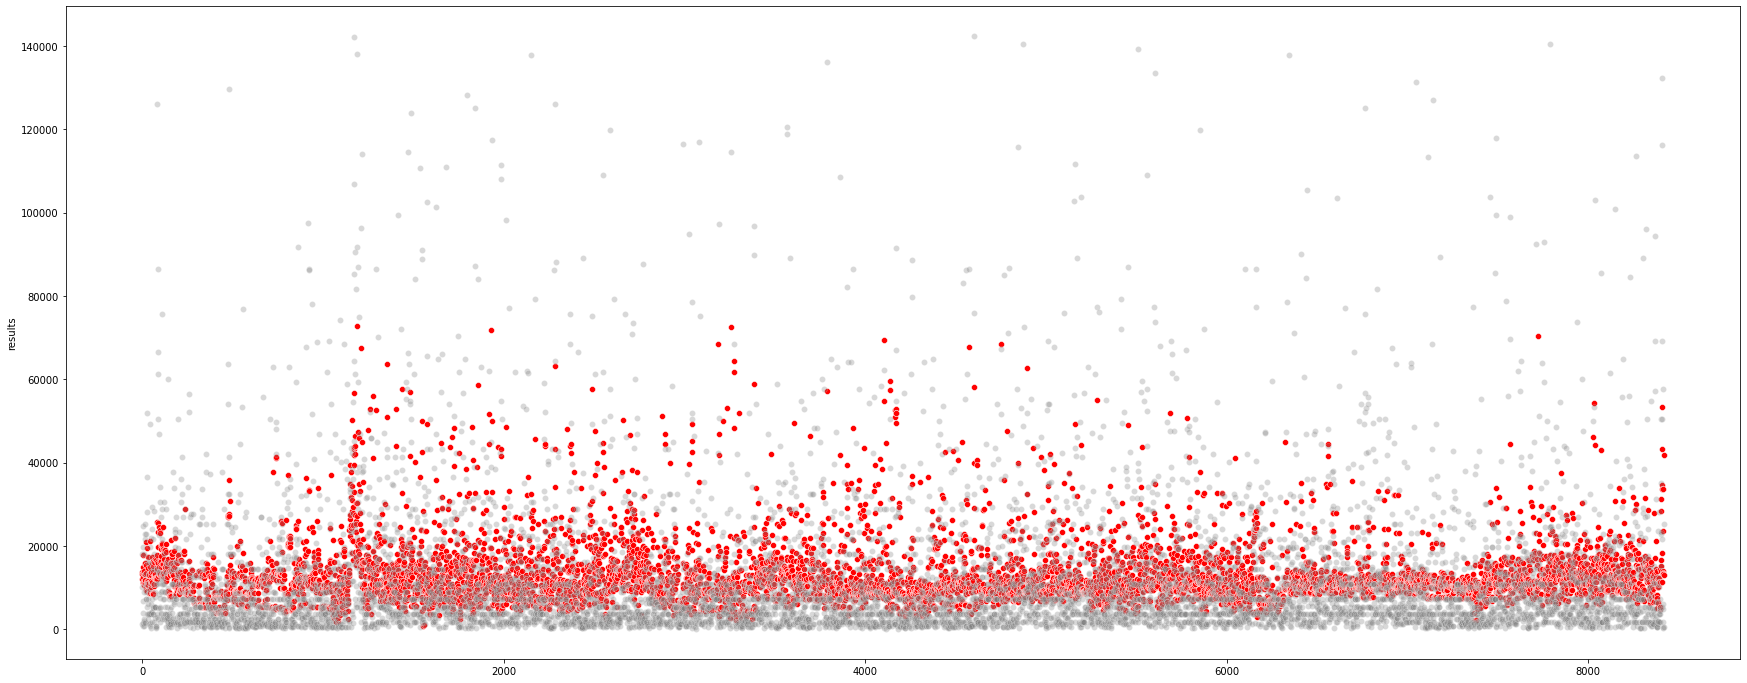

In [74]:
# sns.scatterplot(data=train, x='views', y='res_views', hue='site')
plt.figure(figsize=(30,12))
# train[['res_views', 'views']].plot(kind='scatter')
# train['views'].plot(alpha = 0.25)

sns.scatterplot(data=res_all, x=res_all.index, y='results', color='r')
sns.scatterplot(data=res_all, x=res_all.index, y='overall_worklogs', color='grey', alpha=0.3)

# Тестовые данные

In [75]:
for col in cols_stat:
  df_issues_test[col] = df_issues_test[col].fillna(train[col].mean())

In [76]:
df_issues_test = df_issues_test.fillna(-999)

In [77]:
sample_sol = pd.read_csv(PATH + "/sample_solution.csv")
sample_sol

,id,overall_worklogs
0,675975,0
1,675972,0
2,675965,0
3,675961,0
4,675955,0
...,...,...
1065,702545,0
1066,702528,0
1067,702499,0
1068,702376,0


In [78]:
model_cat = CatBoostRegressor(random_state = 1433,
    loss_function= 'RMSE',
    iterations=4000,
    depth = 6,
    verbose=100,
    cat_features=cat_features
    )
model_cat.fit(train[cols],train[target_col],
)

res = model_cat.predict(df_issues_test[cols])
df_issues_test[target_col] = res

Learning rate set to 0.018574
0:	learn: 16460.1824406	total: 30.3ms	remaining: 2m
100:	learn: 14516.5020095	total: 2.79s	remaining: 1m 47s
200:	learn: 14076.1970943	total: 5.51s	remaining: 1m 44s
300:	learn: 13820.7302147	total: 8.15s	remaining: 1m 40s
400:	learn: 13619.9202987	total: 10.8s	remaining: 1m 37s
500:	learn: 13429.6164324	total: 13.6s	remaining: 1m 34s
600:	learn: 13256.5741537	total: 16.3s	remaining: 1m 32s
700:	learn: 13072.7733732	total: 19s	remaining: 1m 29s
800:	learn: 12933.0016916	total: 21.8s	remaining: 1m 26s
900:	learn: 12794.5558838	total: 24.5s	remaining: 1m 24s
1000:	learn: 12675.1568504	total: 27.3s	remaining: 1m 21s
1100:	learn: 12555.4057562	total: 30s	remaining: 1m 19s
1200:	learn: 12451.8560921	total: 32.8s	remaining: 1m 16s
1300:	learn: 12332.1254518	total: 35.6s	remaining: 1m 13s
1400:	learn: 12235.3548967	total: 38.4s	remaining: 1m 11s
1500:	learn: 12143.3221890	total: 41.2s	remaining: 1m 8s
1600:	learn: 12054.5755280	total: 44s	remaining: 1m 5s
1700:	l

In [79]:
sample_sol = pd.merge(sample_sol, df_issues_test[['id','overall_worklogs']], how='left',left_on=['id'], right_on=['id'])
sample_sol = sample_sol[['id','overall_worklogs_y']]
sample_sol = sample_sol.rename(columns={'id':'id','overall_worklogs_y': 'overall_worklogs'})

sample_sol

,id,overall_worklogs
0,675975,24836.543316
1,675972,19761.651818
2,675965,12371.781851
3,675961,16434.454379
4,675955,41683.145543
...,...,...
1065,702545,15533.779291
1066,702528,11361.153550
1067,702499,10095.948118
1068,702376,17260.319825


In [80]:
df_issues_test[['id_x','overall_worklogs']]

KeyError: ignored

In [ ]:
sample_sol.to_csv('136.csv', index=False)